In [2]:
# Import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

# Set random seed 
RSEED = 42

In [3]:
# Load the data

df = pd.read_csv("../01_data/customer_features_and_clv.csv")

In [4]:
df.head()

,customer_id,signup_date,age_at_signup,income_at_signup,initial_deposit,segment,credit_score_initial,avg_balance_3y,total_deposits_3y,total_withdrawals_3y,...,defaulted_in_3y,CLV_3Y_TARGET,avg_balance_full_history,total_deposits_full_history,total_withdrawals_full_history,total_fees_full_history,num_transactions_full_history,has_mortgage_full_history,has_investment_full_history,defaulted_full_history
0,CUST-00001,2018-08-01,43,95825.86,587.98,Professional,610,16106.206860,48757.757718,14257.574217,...,False,769.779309,107346.279847,85565.645944,37108.352890,262.5,522,True,True,False
1,CUST-00002,2018-11-23,36,64064.02,2624.95,Professional,487,6253.179770,22989.720322,12516.904509,...,True,-14682.363865,3673.407644,22989.720322,12516.904509,62.5,237,False,False,True
2,CUST-00003,2018-06-04,27,86588.21,4488.20,Professional,474,111970.986010,46231.956752,18402.342870,...,False,4956.194370,78664.004878,46231.956752,20207.244654,70.0,316,True,False,True
3,CUST-00004,2019-12-20,41,47881.26,1098.20,Professional,346,15559.878605,36745.341596,12687.965847,...,False,622.694537,17609.453546,41944.139833,18518.545576,147.5,375,False,False,False
4,CUST-00005,2020-11-06,18,10978.99,230.08,Student,346,166.854410,5736.472925,5610.815449,...,True,-16088.019166,158.874417,5736.472925,5610.815449,10.0,126,False,False,True


In [5]:
df.columns

Index(['customer_id', 'signup_date', 'age_at_signup', 'income_at_signup',
       'initial_deposit', 'segment', 'credit_score_initial', 'avg_balance_3y',
       'total_deposits_3y', 'total_withdrawals_3y', 'total_fees_3y',
       'num_transactions_3y', 'has_mortgage_3y', 'has_investment_3y',
       'revenue_interest_3y', 'revenue_fees_3y', 'cost_serve_3y',
       'loss_given_default_3y', 'defaulted_in_3y', 'CLV_3Y_TARGET',
       'avg_balance_full_history', 'total_deposits_full_history',
       'total_withdrawals_full_history', 'total_fees_full_history',
       'num_transactions_full_history', 'has_mortgage_full_history',
       'has_investment_full_history', 'defaulted_full_history'],
      dtype='object')

### EDA and Data Cleaning

In [6]:
# The dataset only include 500 rows, which will impair the prediction accuracy
# --> Watch out for overfitting

df.shape

(500, 28)

In [7]:
# Data is clean

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     500 non-null    object 
 1   signup_date                     500 non-null    object 
 2   age_at_signup                   500 non-null    int64  
 3   income_at_signup                500 non-null    float64
 4   initial_deposit                 500 non-null    float64
 5   segment                         500 non-null    object 
 6   credit_score_initial            500 non-null    int64  
 7   avg_balance_3y                  500 non-null    float64
 8   total_deposits_3y               500 non-null    float64
 9   total_withdrawals_3y            500 non-null    float64
 10  total_fees_3y                   500 non-null    float64
 11  num_transactions_3y             500 non-null    int64  
 12  has_mortgage_3y                 500 

In [8]:
# Convert sign up date to datetime

df['signup_date'] = pd.to_datetime(df['signup_date'])

In [9]:
df = df.drop('customer_id', axis=1)

In [10]:
df.describe()

,signup_date,age_at_signup,income_at_signup,initial_deposit,credit_score_initial,avg_balance_3y,total_deposits_3y,total_withdrawals_3y,total_fees_3y,num_transactions_3y,revenue_interest_3y,revenue_fees_3y,cost_serve_3y,loss_given_default_3y,CLV_3Y_TARGET,avg_balance_full_history,total_deposits_full_history,total_withdrawals_full_history,total_fees_full_history,num_transactions_full_history
count,500,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2019-07-10 09:59:02.400000,43.786000,48094.443960,6810.27468,452.818000,16593.685728,34470.734559,12631.221028,122.105000,253.900000,746.715858,122.105000,150.0,6382.460822,-5663.639964,22975.881621,42034.199051,16393.450963,150.905000,316.724000
min,2018-01-06 00:00:00,18.000000,6753.100000,141.13000,300.000000,70.419858,3720.287130,3312.544968,10.000000,87.000000,3.168894,10.000000,150.0,0.000000,-41510.614723,54.320369,3935.507686,3528.025224,10.000000,87.000000
25%,2018-10-07 12:00:00,31.000000,27419.202500,1424.32500,373.750000,5321.794303,20856.128725,10839.078134,90.000000,221.000000,239.480744,90.000000,150.0,0.000000,-12278.568155,3785.626465,21974.308558,10935.722485,97.500000,221.750000
50%,2019-07-30 00:00:00,43.000000,43314.470000,3626.45000,451.000000,11293.192684,31232.304033,13058.315169,122.500000,274.000000,508.193671,122.500000,150.0,0.000000,37.982247,9751.189870,35626.964402,14279.566923,142.500000,287.000000
75%,2020-03-28 12:00:00,57.000000,61110.755000,7988.07250,526.000000,20958.393443,43563.513946,14493.320121,152.500000,290.000000,943.127705,152.500000,150.0,12667.890777,714.233730,24356.951206,53786.777017,20222.573255,200.000000,404.000000
max,2020-12-29 00:00:00,70.000000,196662.110000,78216.21000,711.000000,165526.512600,129900.243690,27175.672492,245.000000,320.000000,7448.693067,245.000000,150.0,41599.972277,7391.193067,300724.204408,177068.644341,58156.354987,367.500000,606.000000
std,NaN,15.023035,28440.610447,9528.84107,100.025672,20173.298799,20189.953402,3005.899608,43.690092,46.565295,907.798446,43.690092,0.0,7745.731180,8036.916316,37105.024131,28247.676119,7884.958543,67.816972,116.772288


In [11]:
df.columns

Index(['signup_date', 'age_at_signup', 'income_at_signup', 'initial_deposit',
       'segment', 'credit_score_initial', 'avg_balance_3y',
       'total_deposits_3y', 'total_withdrawals_3y', 'total_fees_3y',
       'num_transactions_3y', 'has_mortgage_3y', 'has_investment_3y',
       'revenue_interest_3y', 'revenue_fees_3y', 'cost_serve_3y',
       'loss_given_default_3y', 'defaulted_in_3y', 'CLV_3Y_TARGET',
       'avg_balance_full_history', 'total_deposits_full_history',
       'total_withdrawals_full_history', 'total_fees_full_history',
       'num_transactions_full_history', 'has_mortgage_full_history',
       'has_investment_full_history', 'defaulted_full_history'],
      dtype='object')

In [12]:
# Create column for sign up year

df['sign_up_year'] = df['signup_date'].dt.year

In [13]:
# Deposit/Withdrawal ratios

df['deposit_withdrawal_ratio_3y'] = (df['total_deposits_3y'] + 1) / (df['total_withdrawals_3y'] + 1)
df['deposit_withdrawal_ratio_full'] = (df['total_deposits_full_history'] + 1) / (df['total_withdrawals_full_history'] + 1)

In [14]:
# Create separate dataframes for numerical and categorical values (including target variable y)

# Define target column
target_col = 'CLV_3Y_TARGET'


# Identify column groups based on your data
categorical_cols = [
    'segment', 
    'has_mortgage_3y',  
    'has_investment_3y',
    'defaulted_in_3y',  
    'has_mortgage_full_history', 
    'has_investment_full_history', 
    'defaulted_full_history',
    'sign_up_year'
]

numerical_cols = [
    'age_at_signup',
    'income_at_signup',
    'initial_deposit',
    'credit_score_initial',
    'avg_balance_3y',
    'total_deposits_3y',
    'total_withdrawals_3y',
    'total_fees_3y',
    'num_transactions_3y',
    'revenue_interest_3y',
    'revenue_fees_3y',
    'cost_serve_3y',
    'loss_given_default_3y',
    'avg_balance_full_history',
    'total_deposits_full_history',
    'total_withdrawals_full_history',
    'total_fees_full_history',
    'num_transactions_full_history',
    'deposit_withdrawal_ratio_3y',
    'deposit_withdrawal_ratio_full'
]

# Add target to both lists
categorical_cols_with_target = categorical_cols + [target_col]
numerical_cols_with_target = numerical_cols + [target_col]

# Create DataFrames
df_categorical = df[categorical_cols_with_target].copy()
df_numerical = df[numerical_cols_with_target].copy()

print("Categorical DataFrame shape:", df_categorical.shape)
print("Categorical columns:", df_categorical.columns.tolist())
print("\nNumerical DataFrame shape:", df_numerical.shape)
print("Numerical columns:", df_numerical.columns.tolist())

Categorical DataFrame shape: (500, 9)
Categorical columns: ['segment', 'has_mortgage_3y', 'has_investment_3y', 'defaulted_in_3y', 'has_mortgage_full_history', 'has_investment_full_history', 'defaulted_full_history', 'sign_up_year', 'CLV_3Y_TARGET']

Numerical DataFrame shape: (500, 21)
Numerical columns: ['age_at_signup', 'income_at_signup', 'initial_deposit', 'credit_score_initial', 'avg_balance_3y', 'total_deposits_3y', 'total_withdrawals_3y', 'total_fees_3y', 'num_transactions_3y', 'revenue_interest_3y', 'revenue_fees_3y', 'cost_serve_3y', 'loss_given_default_3y', 'avg_balance_full_history', 'total_deposits_full_history', 'total_withdrawals_full_history', 'total_fees_full_history', 'num_transactions_full_history', 'deposit_withdrawal_ratio_3y', 'deposit_withdrawal_ratio_full', 'CLV_3Y_TARGET']


Check for correlation between the features and the target variable (CLV)

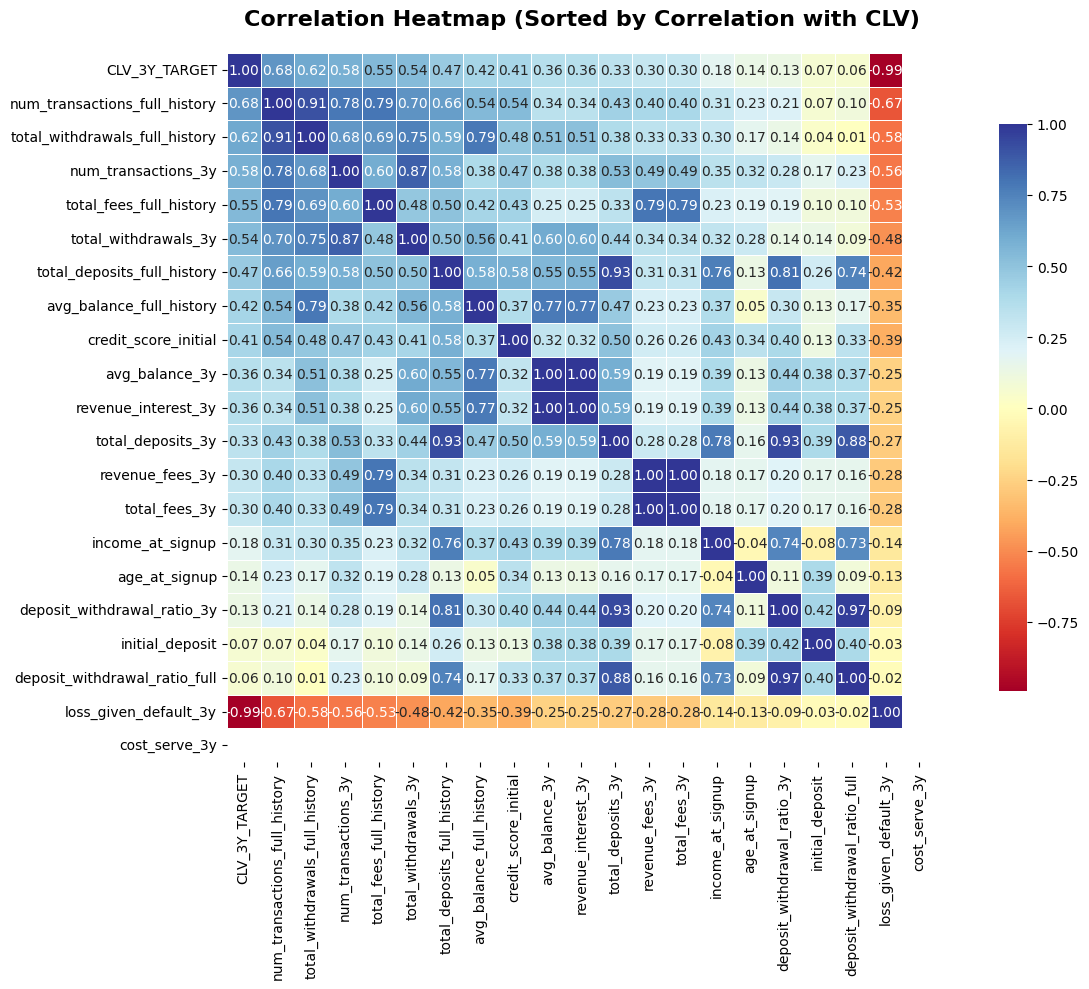

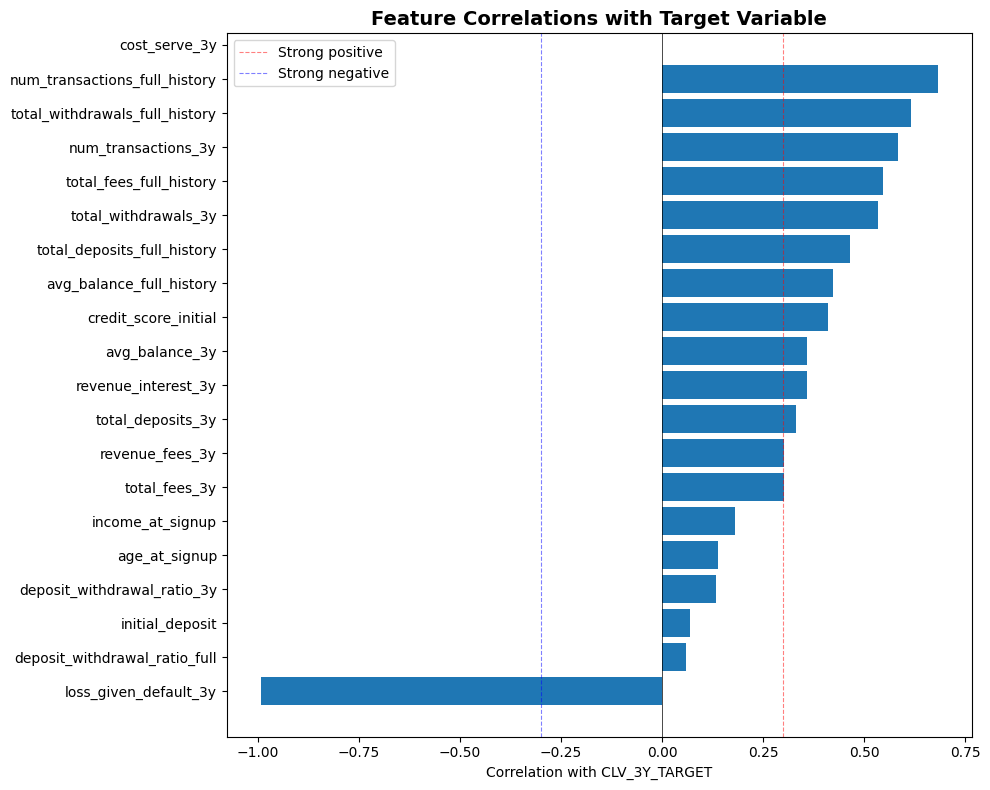

In [15]:
# Set size of chart
plt.figure(figsize=(14, 10))

# Calculate correlations with CLV
clv_correlations = df_numerical.corr(numeric_only=True)[target_col].sort_values(ascending=False)

# Create a DataFrame sorted by correlation with CLV
sorted_features = clv_correlations.index.tolist()
sorted_corr = df_numerical[sorted_features].corr()

# Plot
sns.heatmap(sorted_corr, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlBu',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap (Sorted by Correlation with CLV)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Method 3: Just show correlations with CLV
plt.figure(figsize=(10, 8))
clv_corr_sorted = clv_correlations.drop(target_col).sort_values()

plt.barh(range(len(clv_corr_sorted)), clv_corr_sorted.values)
plt.yticks(range(len(clv_corr_sorted)), clv_corr_sorted.index)
plt.xlabel('Correlation with CLV_3Y_TARGET')
plt.title('Feature Correlations with Target Variable', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=0.3, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong positive')
plt.axvline(x=-0.3, color='blue', linestyle='--', linewidth=0.8, alpha=0.5, label='Strong negative')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/yd/51w8f6v16k72p9k_6y8v7xsw0000gn/T/ipykernel_2200/2334209713.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_categorical,
/var/folders/yd/51w8f6v16k72p9k_6y8v7xsw0000gn/T/ipykernel_2200/2334209713.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_categorical,
/var/folders/yd/51w8f6v16k72p9k_6y8v7xsw0000gn/T/ipykernel_2200/2334209713.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_categorical,
/var/folders/yd/51w8f6v16k72p9k_6y8v7xsw0000gn/T/ipykernel_2200/2334209713.py:27: FutureWarning: 

P

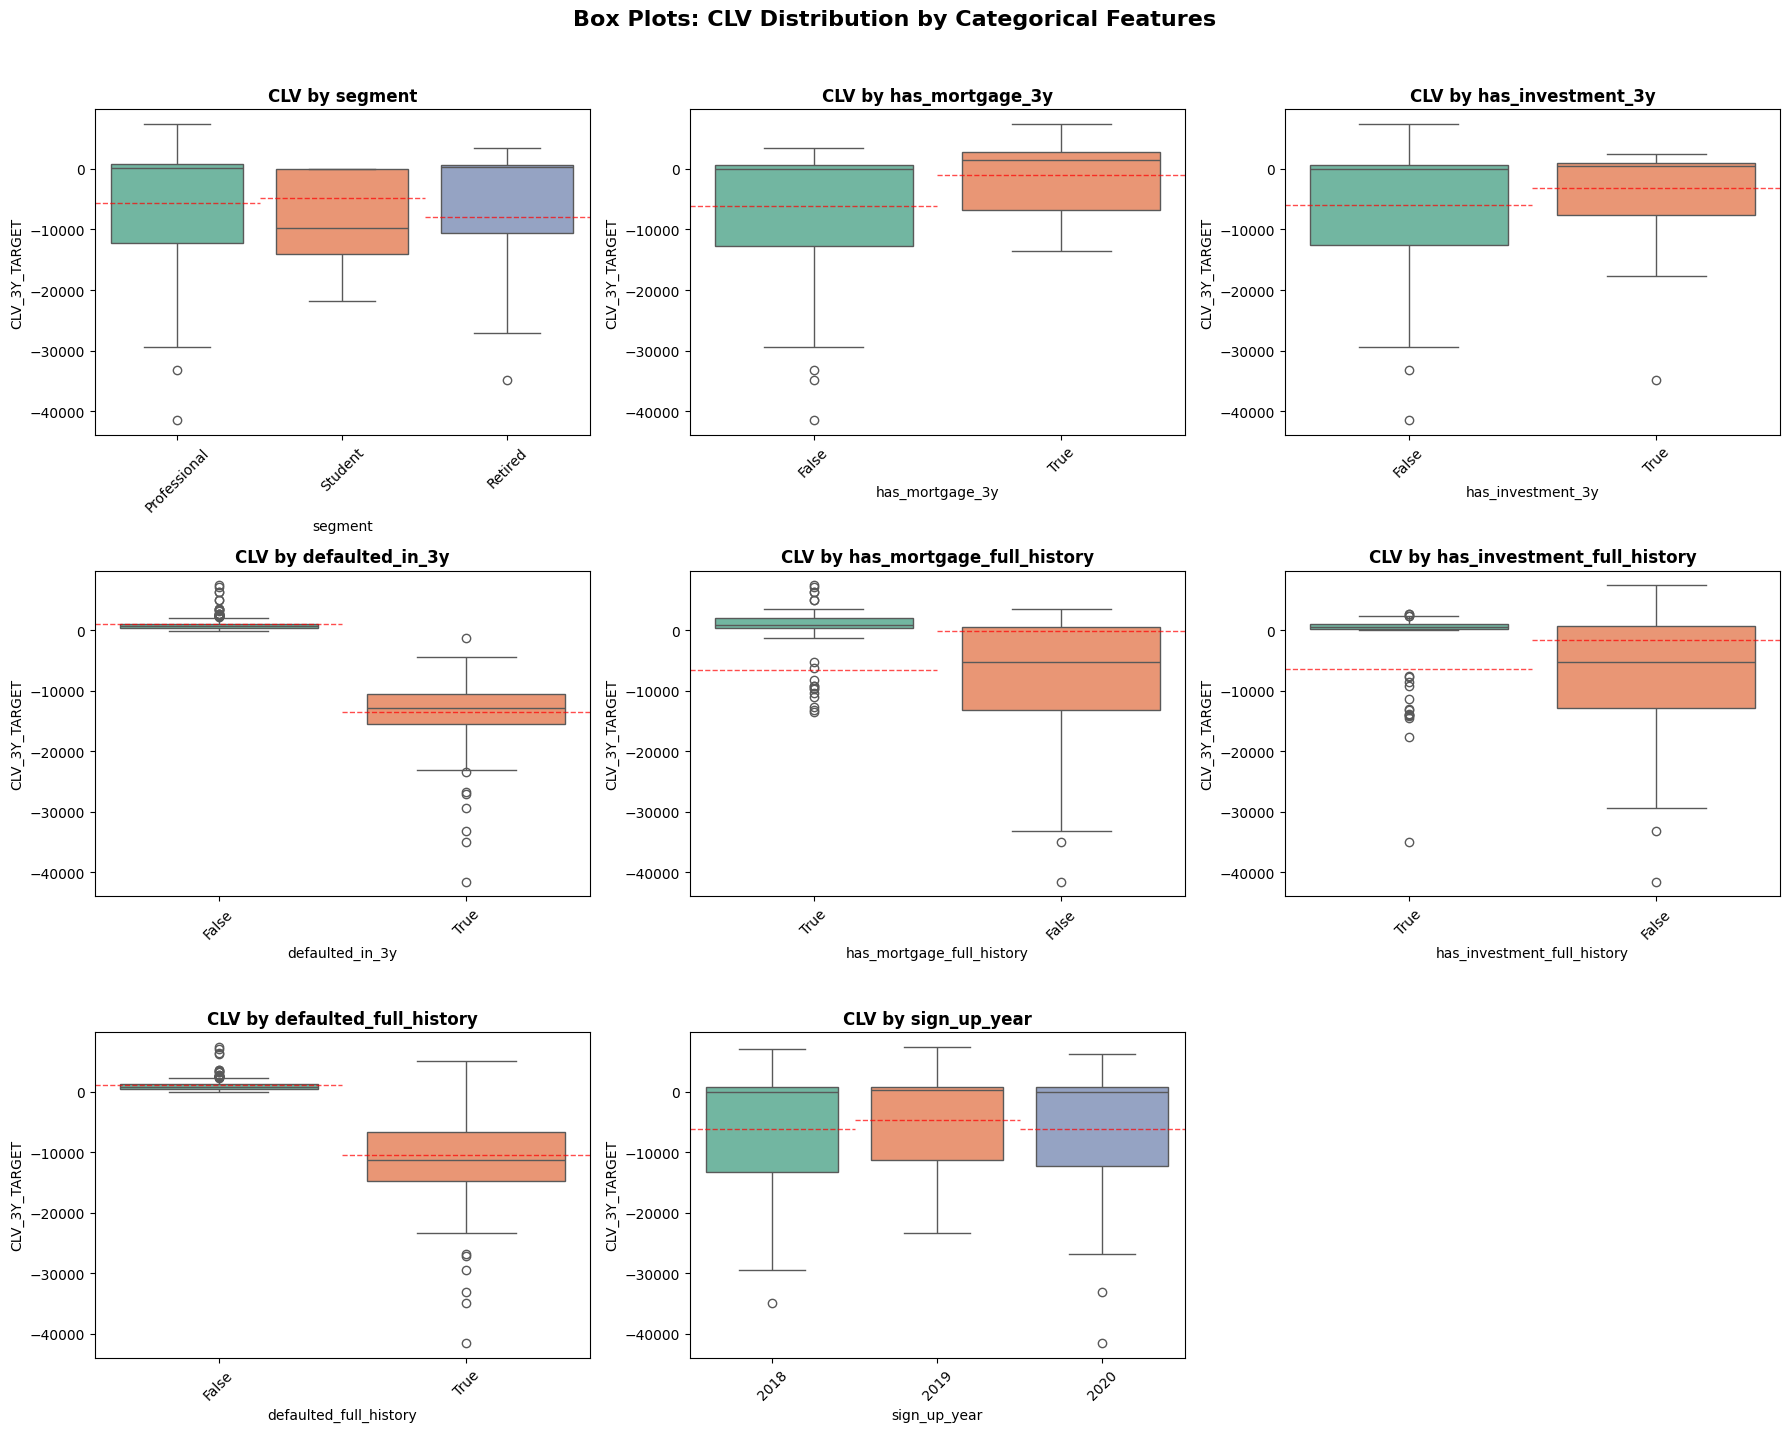

In [16]:
# Assuming df_categorical already exists
# If not, create it:
categorical_cols = [
    'segment', 'has_mortgage_3y', 'has_investment_3y',
    'defaulted_in_3y', 'has_mortgage_full_history',
    'has_investment_full_history', 'defaulted_full_history',
    'sign_up_year', target_col
]
df_categorical = df[categorical_cols].copy()

# Convert binary columns to proper categorical for better visualization
binary_cols = [col for col in df_categorical.columns if 'has_' in col or 'defaulted' in col]
for col in binary_cols:
    if col in df_categorical.columns:
        df_categorical[col] = df_categorical[col].astype(str)

# Method 1: Individual Box Plots
categorical_features = [col for col in df_categorical.columns if col != target_col]

# Create subplots for all categorical features
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    if idx < len(axes):
        # Create box plot
        sns.boxplot(data=df_categorical, 
                    x=feature, 
                    y=target_col, 
                    ax=axes[idx],
                    palette='Set2')
        
        axes[idx].set_title(f'CLV by {feature}', fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('CLV_3Y_TARGET')
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add mean line
        means = df_categorical.groupby(feature)[target_col].mean()
        for i, (cat, mean_val) in enumerate(means.items()):
            axes[idx].axhline(y=mean_val, xmin=i/len(means), xmax=(i+1)/len(means), 
                            color='red', linestyle='--', alpha=0.7, linewidth=1)

# Remove empty subplots
for idx in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Box Plots: CLV Distribution by Categorical Features', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
categorical_cols_with_target.remove('CLV_3Y_TARGET')
numerical_cols_with_target.remove('CLV_3Y_TARGET')


In [18]:
categorical_cols = categorical_cols_with_target
numerical_cols = numerical_cols_with_target

### Train test split

In [19]:
# Define predictors and target variable
X = df.drop('CLV_3Y_TARGET', axis=1)
y = df['CLV_3Y_TARGET']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 500 observations in our dataset and 29 features
Our target vector has also 500 values


In [20]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [21]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (400, 29)
X_test shape: (100, 29)
y_train shape: (400,)
y_test shape: (100,)


In [22]:
X_train.columns

Index(['signup_date', 'age_at_signup', 'income_at_signup', 'initial_deposit',
       'segment', 'credit_score_initial', 'avg_balance_3y',
       'total_deposits_3y', 'total_withdrawals_3y', 'total_fees_3y',
       'num_transactions_3y', 'has_mortgage_3y', 'has_investment_3y',
       'revenue_interest_3y', 'revenue_fees_3y', 'cost_serve_3y',
       'loss_given_default_3y', 'defaulted_in_3y', 'avg_balance_full_history',
       'total_deposits_full_history', 'total_withdrawals_full_history',
       'total_fees_full_history', 'num_transactions_full_history',
       'has_mortgage_full_history', 'has_investment_full_history',
       'defaulted_full_history', 'sign_up_year', 'deposit_withdrawal_ratio_3y',
       'deposit_withdrawal_ratio_full'],
      dtype='object')

### Preprocessing Pipeline

In [23]:
# Create separate pipelines for feature engineering of numerical and categorical values

# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [24]:
# Complete pipeline for numerical and categorical features
# 'ColumnTransformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (numerical_cols/categorical_cols)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

### Predictive Modelling Pipeline

In [25]:
# Building a full pipeline with our preprocessor and a LinearRegression predictor

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),  # Select top 10 features
    ('lr', LinearRegression())
])

In [26]:
pipe_lr

,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_lr, X_train, y_train, cv=5)

In [42]:
# Calculating regression metrics for Linear Regression
print('Cross validation scores for Linear Regression (CLV Prediction):')
print('---------------------------------------------------------------')

# Regression metrics
mse = mean_squared_error(y_train, y_train_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_train_predicted)
r2 = r2_score(y_train, y_train_predicted)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")  # Higher is better, max 1.0

Cross validation scores for Linear Regression (CLV Prediction):
---------------------------------------------------------------
Mean Squared Error (MSE): 421620.95
Root Mean Squared Error (RMSE): 649.32
Mean Absolute Error (MAE): 472.53
R² Score: 0.9932


In [32]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'lr__' in front of the corresponding hyperparameters. 
param_lr = {
    'lr__fit_intercept': [True, False],
    'lr__positive': [True, False]  # Force positive coefficients
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_lr,
    cv=5,
    scoring='r2',
    verbose=1)

Hyperparameter tuning with GridSearch

In [33]:
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,estimator,Pipeline(step...egression())])
,param_grid,"{'lr__fit_intercept': [True, False], 'lr__positive': [True, False]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [34]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_lr.best_score_))
print("Best parameters:\n{}".format(grid_lr.best_params_))

Best score:
0.99
Best parameters:
{'lr__fit_intercept': False, 'lr__positive': False}


Model Evaluation

In [35]:
# Make predictions with best model
best_model = grid_lr.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def print_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{dataset_name}:")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    return r2, rmse, mae

# Compare train vs test
train_r2, train_rmse, train_mae = print_metrics(y_train, y_train_pred, "Training Set")
test_r2, test_rmse, test_mae = print_metrics(y_test, y_test_pred, "Test Set")


Training Set:
  R²: 0.9937
  RMSE: 621.83
  MAE: 454.73

Test Set:
  R²: 0.9924
  RMSE: 756.70
  MAE: 501.85


In [36]:
print("\nOVERFITTING CHECK:")
print("="*50)

# Rule of thumb: If test R² is much lower than train R², it's overfitting
r2_difference = train_r2 - test_r2
print(f"R² difference (train - test): {r2_difference:.4f}")

if r2_difference > 0.1:  # More than 10% drop
    print("⚠️  WARNING: Possible overfitting!")
elif r2_difference > 0.05:  # 5-10% drop
    print("⚠️  Caution: Some overfitting detected")
else:
    print("✅ Good: Minimal overfitting")

# RMSE comparison
rmse_ratio = test_rmse / train_rmse
print(f"\nRMSE ratio (test/train): {rmse_ratio:.2f}")
if rmse_ratio > 1.5:
    print("⚠️  WARNING: High RMSE increase on test set")


OVERFITTING CHECK:
R² difference (train - test): 0.0013
✅ Good: Minimal overfitting

RMSE ratio (test/train): 1.22


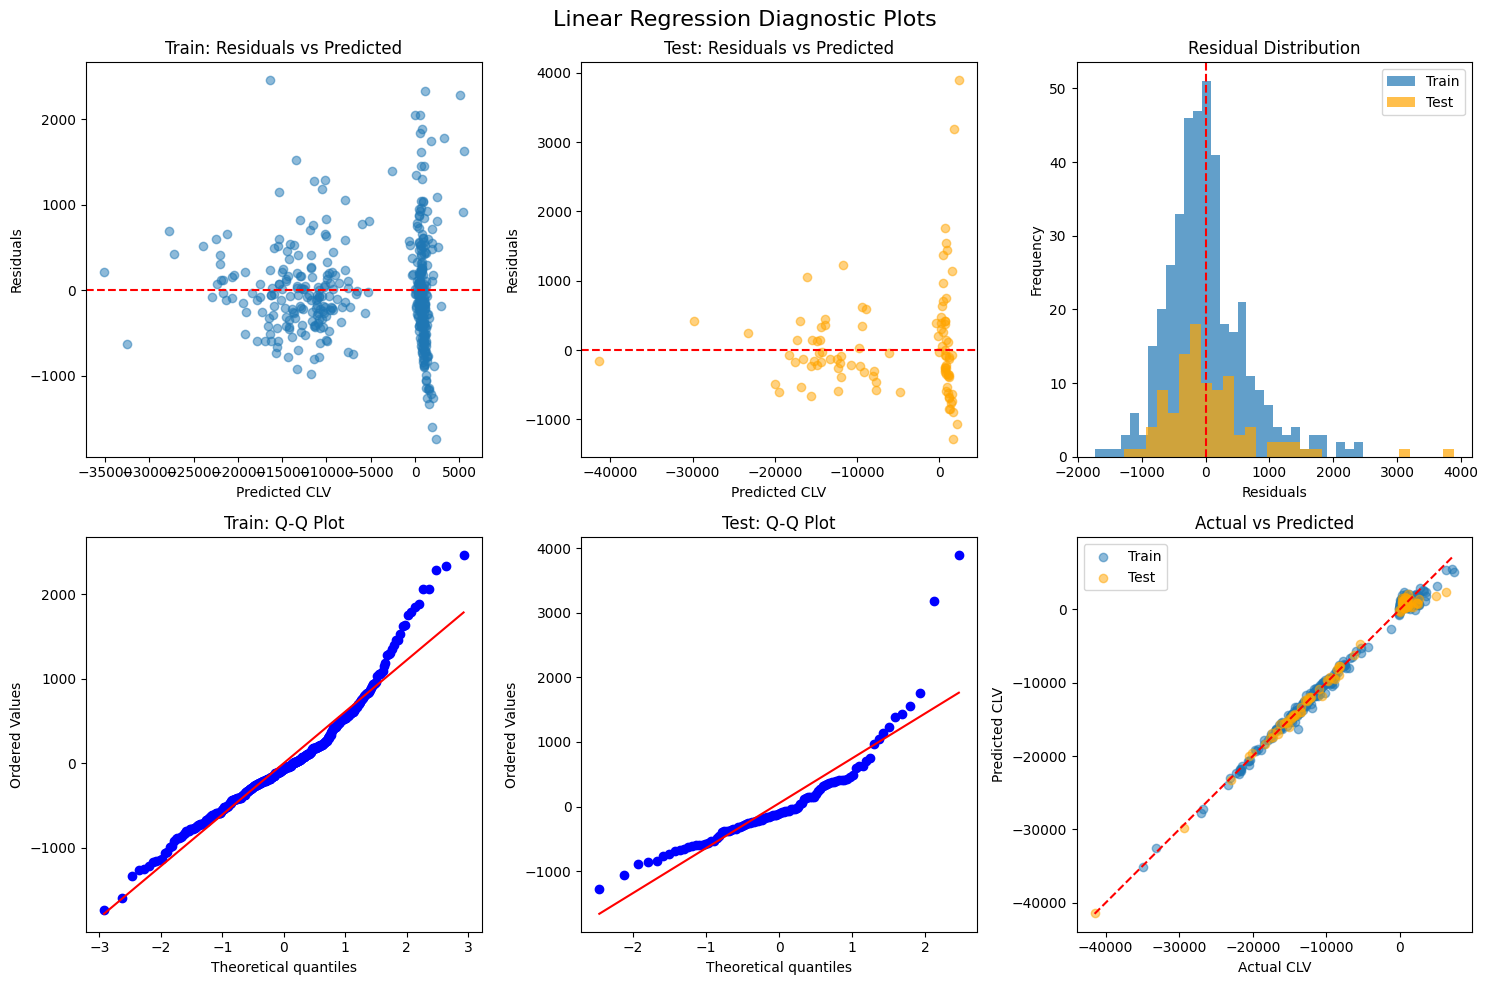

In [37]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Residuals vs Predicted (Train)
axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted CLV')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Train: Residuals vs Predicted')

# 2. Residuals vs Predicted (Test)
axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.5, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted CLV')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Test: Residuals vs Predicted')

# 3. Residual distribution (Train)
axes[0, 2].hist(train_residuals, bins=30, alpha=0.7, label='Train')
axes[0, 2].hist(test_residuals, bins=30, alpha=0.7, label='Test', color='orange')
axes[0, 2].axvline(x=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Residuals')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Residual Distribution')
axes[0, 2].legend()

# 4. Q-Q plot of residuals
from scipy import stats
stats.probplot(train_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Train: Q-Q Plot')

stats.probplot(test_residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Test: Q-Q Plot')

# 5. Actual vs Predicted
axes[1, 2].scatter(y_train, y_train_pred, alpha=0.5, label='Train')
axes[1, 2].scatter(y_test, y_test_pred, alpha=0.5, color='orange', label='Test')
axes[1, 2].plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
                [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
                'r--')
axes[1, 2].set_xlabel('Actual CLV')
axes[1, 2].set_ylabel('Predicted CLV')
axes[1, 2].set_title('Actual vs Predicted')
axes[1, 2].legend()

plt.suptitle('Linear Regression Diagnostic Plots', fontsize=16)
plt.tight_layout()
plt.show()

##### Residuals vs. Predicted:

Checks for heteroscedasticity (The residuals should be randomly scattered around zero with no clear pattern (like a funnel, curve, or trend))

In our case the model seem a bit worse in predicting higher CLV, but no systemic pattern. Similar pattern for test and train sets which indicate no overfitting.

##### Q-Q Plot:

Checks whether residuals are normally distributed. Points should fall along the straight diagonal line.

In our model very big and small errors slightly deviate from the diagonal line, otherwise the residuals follow diagonal line closely. Residuals are normally distributed as confirmed by the histogram. Test and train follow a similar pattern.

##### Actual vs. predicted:

Predictions should be close to the x = y line (perfect predictions). Systematic deviation (e.g., under-predicting high values, over-predicting low values) suggests model bias.

Predictions are clustered along diagonal line. Only slight deviation for higher values.